# Wholesale Customer

This notebook focusses on modeling using sklearn.

## 1. Data preparation

Algorithms for training need that the whole data is numeric, for that reason categorical variables are going to be transformed into numeric values. With respect to numeric features, these must be in the same scale in order to improve training performance.

Finally, it is important to determine if all features are useful for training or some of them are only noise.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
plt.style.use("ggplot")

In [3]:
PATH_DATA = os.path.join(os.getenv("PATH_DATA_PROJECTS"), "Tabular", "wholesale_customers")

In [4]:
df_train = pd.read_csv(os.path.join(PATH_DATA, "wholesale_customers_cleaned.csv"))
print("Shape:", df_train.shape)
df_train.head()

Shape: (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


### 1.1. Categorical

Even though these variables are numeric and ordinal, but it is not clear that they come from a ranking. So, for the purpose of this project they are going to be treated as non-ordinal and be transformed using OneHotEncoder.

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
categorical_features = ["Channel", "Region"]

In [8]:
# Get transformer instance 
# sparse_output = False to return the values as vectors
# drop = first to remove first class, because the rest of classes are enough explanatory and reduce training time 
onehot_encoder = OneHotEncoder(sparse_output = False, drop = "first")

# Training
encoded_features = onehot_encoder.fit_transform(df_train[categorical_features])

# Turn result into a dataframe
df_one_hot_encoder = pd.DataFrame(encoded_features, columns = onehot_encoder.get_feature_names_out())

### 1.2. Numeric

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
numeric_features = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]

In [11]:
mms = MinMaxScaler()
xMMS = mms.fit_transform(df_train[numeric_features].values)
print('Shape:', xMMS.shape)

Shape: (440, 6)


In [12]:
df_MMS = pd.DataFrame(data = xMMS, columns = numeric_features)
df_MMS.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.106977,0.078173,0.085671,0.050078,0.070510,0.031745
std,0.112774,0.100491,0.102430,0.079789,0.116790,0.058826
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027863,0.020124,0.023174,0.011788,0.006216,0.008453
50%,0.075802,0.048636,0.051225,0.024670,0.019927,0.020077
75%,0.150968,0.097154,0.114821,0.058005,0.095997,0.037907
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: title={'center': 'Numeric features distribution after scaling (MinMaxScaler)'}, ylabel='Density'>

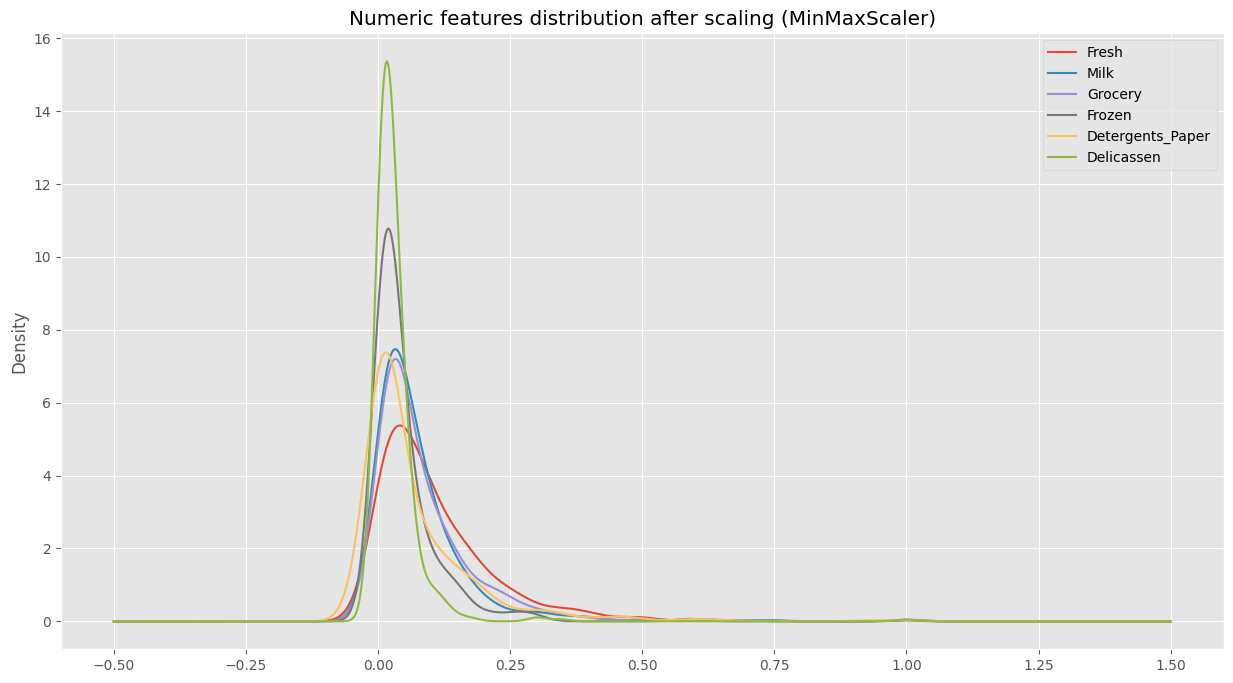

In [13]:
df_MMS.plot(kind = "kde", figsize = (15, 8), title = "Numeric features distribution after scaling (MinMaxScaler)")

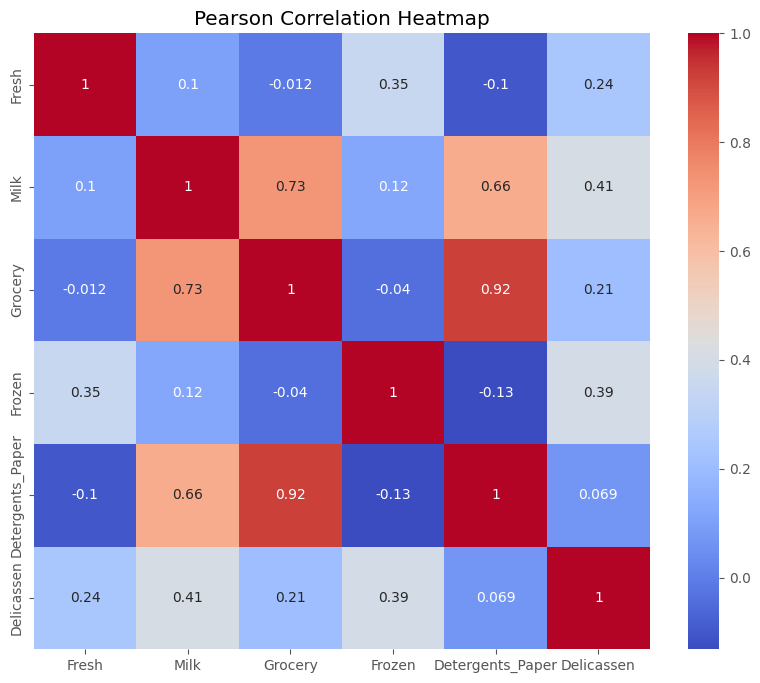

In [14]:
correlation_matrix = df_MMS.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Pearson Correlation Heatmap')
plt.show()

There is a strong correlation between Grocery and Detergents_Paper, so one of them can explain both variables and Detergents_Paper variable is going to ber removed.

In [15]:
df_MMS = df_MMS.drop(["Detergents_Paper"], axis = 1)
df_MMS.head()

,Fresh,Milk,Grocery,Frozen,Delicassen
0,0.112940,0.130727,0.081464,0.003106,0.027847
1,0.062899,0.132824,0.103097,0.028548,0.036984
2,0.056622,0.119181,0.082790,0.039116,0.163559
3,0.118254,0.015536,0.045464,0.104842,0.037234
4,0.201626,0.072914,0.077552,0.063934,0.108093


### 1.3. Get transformed dataset

In [16]:
df_train_encoded = pd.concat([df_MMS, df_one_hot_encoder], axis = 1)
print("Shape:", df_train_encoded.shape)
df_train_encoded.head()

Shape: (440, 8)


,Fresh,Milk,Grocery,Frozen,Delicassen,Channel_2,Region_2,Region_3
0,0.112940,0.130727,0.081464,0.003106,0.027847,1.0,0.0,1.0
1,0.062899,0.132824,0.103097,0.028548,0.036984,1.0,0.0,1.0
2,0.056622,0.119181,0.082790,0.039116,0.163559,1.0,0.0,1.0
3,0.118254,0.015536,0.045464,0.104842,0.037234,0.0,0.0,1.0
4,0.201626,0.072914,0.077552,0.063934,0.108093,1.0,0.0,1.0


## 2. Modeling

### 2.1. Clustering

In [17]:
from sklearn.cluster import KMeans

In [18]:
x_train = df_train_encoded.values

#### 2.1.1. Select the best number of clusters

In [19]:
elbowResult = { "K": [], "WCSS": [] }
for k in range(2, 16):
    kms = KMeans(n_clusters = k, n_init = "auto", random_state = 42)
    kms.fit(x_train)
    elbowResult["K"].append(k)
    elbowResult["WCSS"].append(kms.inertia_)

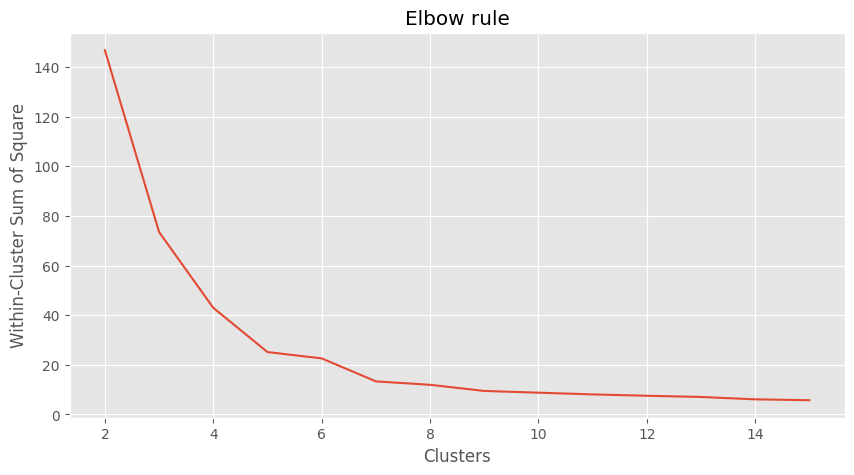

In [20]:
plt.figure(figsize = (10, 5))
plt.xlabel("Clusters")
plt.ylabel("Within-Cluster Sum of Square")
plt.plot(elbowResult["K"], elbowResult["WCSS"])
plt.title("Elbow rule")
plt.show()

In [21]:
number_optimal_cluster = 4

#### 2.1.2. Training using optimal clusters

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
kms = KMeans(n_clusters = number_optimal_cluster, n_init = "auto", random_state = 42)

param_grid = {
    "algorithm": ["lloyd", "elkan"],

    "init": ["k-means++", "random"],
}

clf = GridSearchCV(kms, param_grid, cv = 3, verbose = 2, n_jobs = -1)
random_search_kms = clf.fit(x_train)

print("\nBest hyperparameters:", random_search_kms.best_params_)
#print("\nBest score: ", random_search_kms.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best hyperparameters: {'algorithm': 'lloyd', 'init': 'k-means++'}


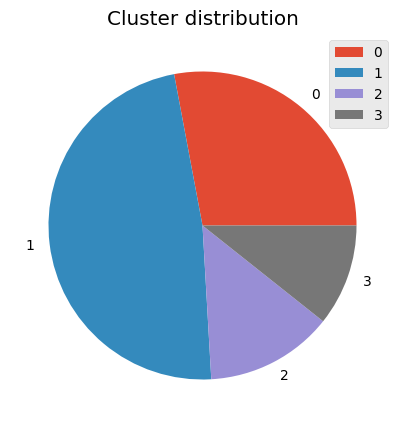

In [24]:
pred = random_search_kms.predict(x_train)

counts = np.unique(pred, return_counts = True)

fig = plt.figure(figsize = (5, 5))
plt.pie(counts[1], labels = counts[0])
plt.legend(counts[0], loc = "upper right")
plt.title("Cluster distribution")
plt.show()

### 2.2. Classifier

#### 2.2.1. Split data into training and validation

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train, pred, test_size = 0.2, random_state = 42)

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (352, 8)
x_val shape: (88, 8)
y_train shape: (352,)
y_val shape: (88,)


#### 2.2.2. Training

In [27]:
from xgboost import XGBClassifier

In [28]:
# Hyperparameter tunning
hyperParameters = { "n_estimators": (80, 100), "max_depth": (4, 7) }
xgb = XGBClassifier(objective = "binary:logistic")
random_search_xg = GridSearchCV(xgb, hyperParameters, refit = True)

# Training
random_search_xg.fit(x_train, y_train)

print("Best hyperparameters:", random_search_xg.best_params_)
print("Best score:", random_search_xg.best_score_)

Best hyperparameters: {'max_depth': 4, 'n_estimators': 80}
Best score: 1.0


#### 2.2.3. Evaluation

This is a classification problem, so the following metrics are necessary:

* **Accuracy**: proportion of correctly predicted to the total of all instances.
* **Precision**: proportion of correctly predicted positive to the total of all predicted positive. When False Positive cost is high.
* **Recall**: proportion of correctly predicted positive to the total of all positive. When False Negative cost is high.
* **F1 score**: mean of precision and recall.
* **Confusion matrix**: table which shows True Positives, True Negatives, False Positives and False Negatives.
* **Classification report**: summary of the most common metrics.

In [29]:
from sklearn import metrics

In [30]:
# Prediction
y_pred = random_search_xg.predict(x_val)

# Accuracy
print("\nAccuracy:", metrics.accuracy_score(y_val, y_pred))

# Precision
print("\nPrecision:", metrics.precision_score(y_val, y_pred, average = "weighted"))

# Recall
print("\nRecall:", metrics.recall_score(y_val, y_pred, average = "weighted"))

# F1
print("\nF1:", metrics.f1_score(y_val, y_pred, average = "weighted"))

# Confusion Matrix
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_val, y_pred))

# Classification Report
print("\nClassification Report:")
print(metrics.classification_report(y_val, y_pred))


Accuracy: 1.0

Precision: 1.0

Recall: 1.0

F1: 1.0

Confusion Matrix:
[[19  0  0  0]
 [ 0 56  0  0]
 [ 0  0  8  0]
 [ 0  0  0  5]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         5

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88

